In [704]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../../../data_set/train-data.csv', index_col=0)

df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [705]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

Controllo della variabile '**Mileage**'. Essa è espressa come stringa, nel formato '\<valore\> \<unità di misura\>'

In [706]:
df['Mileage']

0       26.6 km/kg
1       19.67 kmpl
2        18.2 kmpl
3       20.77 kmpl
4        15.2 kmpl
           ...    
6014     28.4 kmpl
6015     24.4 kmpl
6016     14.0 kmpl
6017     18.9 kmpl
6018    25.44 kmpl
Name: Mileage, Length: 6019, dtype: object

Controlliamo se ci sono differenti unità di misura:

In [707]:
mileage_units = df['Mileage'].str.split().str[-1]
mileage_units.unique()

array(['km/kg', 'kmpl', nan], dtype=object)

Notiamo che abbiamo due diverse unità 'km/kg' e 'kmpl'.

Vediamo per quante osservaioni appaiono le varie unità:

In [708]:
mileage_units.value_counts()

Mileage
kmpl     5951
km/kg      66
Name: count, dtype: int64

Abbiamo visto che non ci sono errori o unità di misura fittizie, ci sono solamente alcuni valori mancanti. Vediamo quanti sono:

In [709]:
mileage_units.isna().sum()

np.int64(2)

Abbiamo solo due valori mancanti che gestiremo in seguito.

Inoltre, notiamo che i vari valori di essa utilizzano differenti unità di misura. Questo accade perché tipicamente, per calcolare la quantità carburante consumato al chilometro, si utilizzano propreità diverse in base al tipo carburante dell'auto.

In genere:
- kmpl - chilometri al litro, usato per carburanti liquidi (benzina, diesel, GPL)
- km/kg - chilometri al chilogrammo, usato per carburanti diversi (CNG)

Vorremmo quindi, rimuovere o riempire i valori mancanti e sopratutto standardizzare le differenti unità di misura, in modo da averne solamente una.

Importante: ogni tipo di carburante ha una differente formula di conversione.

In [710]:
df_2 = df[df['Mileage'].isna()]
df_2

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72 CC,41 bhp,5.0,13.58 Lakh,13.00
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798 CC,73 bhp,5.0,NaN,12.75


Vediamo se ci sono valori insensati:

In [711]:
df_copy = df.copy()

df_copy['Mileage'] = df_copy['Mileage'].str.split(' ').str[0]
df_copy['Mileage'] = pd.to_numeric(df_copy['Mileage'], errors='coerce')

# Fattori di conversione da km/l a km/kg
conversion_factors = {
    'Petrol': 1/0.74,   # approssimativo
    'Diesel': 1/0.85,   # approssimativo
    'LPG': 1/0.51,      # approssimativo
    'CNG': 1,            # già in km/kg
    'Electric': np.nan   # non convertibile
}

# Funzione di conversione per riga
def convert_kmpl_to_kmpkg(row):
    fuel = row['Fuel_Type']
    mileage = row['Mileage']
    # Se il valore non è valido o carburante non convertibile
    if pd.isna(mileage) or mileage <= 0 or fuel not in conversion_factors:
        return np.nan
    factor = conversion_factors[fuel]
    return mileage / factor

# Applico la conversione
df_copy['Mileage_kmpkg'] = df_copy.apply(convert_kmpl_to_kmpkg, axis=1)

# Calcolo la mediana dei valori validi
median_value = df_copy['Mileage_kmpkg'].median()

# Riempio i valori NaN (inclusi quelli inizialmente NaN o <=0)
df_copy['Mileage_kmpkg'] = df_copy['Mileage_kmpkg'].fillna(median_value)

df_copy['Mileage'] = df_copy['Mileage_kmpkg']

df_copy.drop(columns=['Mileage_kmpkg'], inplace=True)

In [712]:
bad_values = df_copy.loc[df_copy['Mileage'] <= 0]
print(bad_values.value_counts())

Series([], Name: count, dtype: int64)


Convertiamo

| Fuel     | Potere calorifico | Conversione (L → kg) approssimativa       |
| -------- | ----------------- | ----------------------------------------- |
| Petrol   | 32 MJ/l           | 1 L ≈ 0.74 kg (32/43 MJ/kg)               |
| Diesel   | 36 MJ/l           | 1 L ≈ 0.85 kg (36/42 MJ/kg)               |
| LPG      | 25 MJ/l           | 1 L ≈ 0.51 kg (25/49 MJ/kg)               |
| CNG      | 50 MJ/kg          | 1 L ≈ ??? non serve, lo lasciamo in km/kg |
| Electric | -                 | non convertibile                          |


Dataset fino a **Correzione Inconsistenze e Formattazione**:

In [713]:
df_clean = df.copy()

# Formattiamo bene 'Mileage'
# df_clean['Mileage'] = df_clean['Mileage'].str.split(' ').str[0]
# df_clean['Mileage'] = pd.to_numeric(df_clean['Mileage'], errors='coerce')

# Formattiamo bene 'Power'
df_clean['Power'] = df_clean['Power'].str.split(' ').str[0]
df_clean['Power'] = pd.to_numeric(df_clean['Power'], errors='coerce')

# Formattiamo bene 'New_Price'
df_clean['New_Price'] = df_clean['New_Price'].str.split(' ').str[0]
df_clean['New_Price'] = pd.to_numeric(df_clean['New_Price'], errors='coerce')

# Formattiamo bene 'New_Price'
df_clean['Engine'] = df_clean['Engine'].str.split(' ').str[0]
df_clean['Engine'] = pd.to_numeric(df_clean['Engine'], errors='coerce')

'Mileage' richiede una gestione apparte perché abbiamo due differenti unotà di misura:

In [714]:
df_clean[df_clean['Fuel_Type'] == 'LPG']

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814.0,55.20,5.0,NaN,2.35
936,Maruti Wagon R LXI LPG BSIV,Hyderabad,2012,72000,LPG,Manual,First,26.2 km/kg,998.0,58.20,5.0,NaN,2.85
987,Maruti Wagon R LXI DUO BSIII,Mumbai,2008,64226,LPG,Manual,First,17.3 km/kg,1061.0,57.50,5.0,NaN,1.45
2278,Hyundai Santro Xing GLS LPG,Pune,2010,55000,LPG,Manual,Second,13.45 km/kg,1086.0,62.10,5.0,NaN,1.65
2385,Hyundai Santro Xing GLS LPG,Hyderabad,2011,17000,LPG,Manual,First,13.45 km/kg,1086.0,62.10,5.0,NaN,3.10
2436,Hyundai i10 Magna LPG,Jaipur,2012,53000,LPG,Manual,Second,19.2 km/kg,1086.0,68.05,5.0,NaN,2.85
2941,Hyundai Santro Xing GL Plus LPG,Hyderabad,2014,56000,LPG,Manual,First,13.45 km/kg,1086.0,62.10,5.0,NaN,3.20
3595,Maruti Wagon R LX DUO BSIII,Hyderabad,2007,65047,LPG,Manual,First,17.3 km/kg,1061.0,57.50,5.0,NaN,1.95
5506,Maruti Wagon R Duo LX BSIII,Hyderabad,2012,72389,LPG,Manual,First,26.2 km/kg,998.0,58.20,5.0,NaN,3.20
5997,Maruti Wagon R Duo Lxi,Jaipur,2010,70000,LPG,Manual,First,26.2 km/kg,998.0,58.20,5.0,NaN,2.27


In [715]:
df_clean2 = df.copy()

df_clean2['Mileage_Unit'] = df_clean2['Mileage'].str.split(' ').str[1]

expected_units = {
    'Petrol': 'kmpl',
    'Diesel': 'kmpl',
    'LPG': 'km/kg',
    'CNG': 'km/kg',
    'Electric': None
}

def check_consistency(row):
    expected = expected_units[row['Fuel_Type']]
    actual = row['Mileage_Unit']
    
    if row['Fuel_Type'] == 'Electric':
        return pd.isna(actual)
    
    return actual == expected

df_clean2['Mileage_Consistent'] = df_clean2.apply(check_consistency, axis=1)

consistency_report = (
    df_clean2
    .groupby('Fuel_Type')['Mileage_Consistent']
    .value_counts()
    .unstack(fill_value=0)
)

print(consistency_report)


Mileage_Consistent  True
Fuel_Type               
CNG                   56
Diesel              3205
Electric               2
LPG                   10
Petrol              2746


Se ci fossero state osservazioni inconsistenti avremmo avuto una colonna False contenenti i valori inconsistenti.

In [716]:
# Fattori di conversione da km/l a km/kg
conversion_factors = {
    'Petrol': 1/0.74,   # kmpl → km/kg
    'Diesel': 1/0.85,   # kmpl → km/kg
    'LPG': None,        # già km/kg
    'CNG': None,        # già km/kg
    'Electric': None    # ← RESTA NaN
}

def convert_to_kmpkg(row):
    fuel = row['Fuel_Type']
    value = row['Mileage_Value']
    unit = row['Mileage_Unit']
    
    # Valore mancante
    if pd.isna(value):
        return np.nan
    
    # Electric → lasciamo NaN
    if fuel == 'Electric':
        return np.nan
    
    # Se è già in km/kg → lascia così
    if unit == 'km/kg':
        return value
    
    # Se è in kmpl → converti
    factor = conversion_factors[fuel]
    if unit == 'kmpl' and factor is not None:
        return value / factor
    
    return np.nan

# Estrazione numeri e unità in colonne separate
df_clean['Mileage_Value'] = df_clean['Mileage'].str.split(' ').str[0]
df_clean['Mileage_Value'] = pd.to_numeric(df_clean['Mileage_Value'], errors='coerce')

df_clean['Mileage_Unit'] = df_clean['Mileage'].str.split(' ').str[1]

# Applico la conversione
df_clean['Mileage_kmpkg'] = df_clean.apply(convert_to_kmpkg, axis=1)

median_value = df_clean['Mileage_kmpkg'].median()
df_clean['Mileage_kmpkg'] = df_clean['Mileage_kmpkg'].fillna(median_value)

# Rendo Mileage definitivo
df_clean['Mileage'] = df_clean['Mileage_kmpkg']

df_clean.drop(columns=['Mileage_kmpkg', 'Mileage_Value', 'Mileage_Unit'], inplace=True)

df_clean.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6000,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,16.7195,1582.0,126.20,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199.0,88.70,5.0,8.61,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968.0,140.80,5.0,NaN,17.74


In [717]:
df_clean = df_clean.drop('New_Price', axis=1)

cols_to_impute = ['Power', 'Mileage', 'Engine', 'Seats']
df[cols_to_impute] = df_clean[cols_to_impute].replace(0.0, np.nan)

for col in cols_to_impute:
    median_value = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_value)

df_clean['Engine'] = df_clean['Engine'].astype('int64')
df_clean['Seats'] = df_clean['Seats'].astype('int64')

df_clean['Brand'] = df_clean['Name'].str.split(' ').str[0]
df_clean['Model'] = df_clean['Name'].str.split(' ').str[1]
df_clean = df_clean.drop('Name', axis=1)

df_clean.drop_duplicates(inplace=True)

In [718]:
df_clean.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
0,Mumbai,2010,72000,CNG,Manual,First,26.6000,998,58.16,5,1.75,Maruti,Wagon
1,Pune,2015,41000,Diesel,Manual,First,16.7195,1582,126.20,5,12.50,Hyundai,Creta
2,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199,88.70,5,4.50,Honda,Jazz
3,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248,88.76,7,6.00,Maruti,Ertiga
4,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968,140.80,5,17.74,Audi,A4


### Gestione degli outliers

Controlleremo gli outliers in vari modi variabile per variabile.

Boxplots per variabili continue.

Controllo tramite limiti impostati da me, limiti sensati.

Usare boxplots per vedere quante osservazioni hanno alcune variabili categoriche.

**1. Year**

In [719]:
df_clean['Year'].value_counts()

Year
2014    797
2015    744
2016    740
2013    649
2017    587
2012    580
2011    466
2010    342
2018    298
2009    198
2008    174
2007    124
2019    102
2006     78
2005     57
2004     31
2003     17
2002     15
2001      8
2000      4
1998      4
1999      2
Name: count, dtype: int64

Year non ha valori estremi, non ha outliers.

**2. Kilometers_Driven**

L'unico controllo che si potrebbe fare in Kilometers_Driven è vedere se ci sono osservazioni che hanno valore minore di zero per quella caratteristica.

In [720]:
df_clean['Kilometers_Driven'].value_counts().sort_index()

Kilometers_Driven
171        1
600        1
1000       9
1001       2
1011       1
          ..
480000     2
620000     1
720000     1
775000     1
6500000    1
Name: count, Length: 3093, dtype: int64

Notiamo che il chilometraggio minimo sembra sensato, tuttavia c'è un auto che ha ben 6 milioi di km percorsi, è molto improbabile. Siamo senza dubbio di fronte ad un outlier. Si deve gestire.

In [721]:
df_clean[df_clean['Kilometers_Driven'] > 1000000]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
2328,Chennai,2017,6500000,Diesel,Automatic,First,13.5745,2993,258.0,5,65.0,BMW,X5


In [722]:
df_clean[df_clean['Kilometers_Driven'] < 10].value_counts()

Series([], Name: count, dtype: int64)

**3. Mileage**

In [723]:
df_clean['Mileage'].value_counts().sort_index()

Mileage
0.0000     68
4.7360      1
5.7794      1
5.8756      2
5.9200      1
           ..
30.4600     1
31.7900     2
32.2600     2
33.4400     4
33.5400     5
Name: count, Length: 533, dtype: int64

In [724]:
df_clean[(df_clean['Mileage'] <= 0) & (df_clean['Fuel_Type'] != 'Electric')].value_counts()


Location   Year  Kilometers_Driven  Fuel_Type  Transmission  Owner_Type  Mileage  Engine  Power  Seats  Price  Brand          Model  
Ahmedabad  2005  58000              Petrol     Manual        Second      0.0      999     97.7   5      1.51   Hyundai        Santro     1
           2007  60006              Petrol     Manual        First       0.0      1493    97.7   5      2.95   Honda          City       1
           2012  66000              Diesel     Automatic     First       0.0      2987    165.0  5      23.00  Mercedes-Benz  M-Class    1
           2019  4000               Diesel     Automatic     First       0.0      1950    194.0  5      35.00  Mercedes-Benz  C-Class    1
Bangalore  2002  53000              Petrol     Manual        Second      0.0      1493    97.7   5      1.85   Honda          City       1
                                                                                                                                        ..
Pune       2009  100000         

Notiamo che 68 osservazioni non hanno un valore accettabile per Mileage, questi sono senza dubbio outliers. Possiamo gestirli assegnando a questi valori la mediana del valore di Mileage, più robusta ad altri eventuali outliers non identificati.

In [725]:
# Calcolo mediana solo per le auto non elettriche con Mileage > 0
mileage_median = df_clean.loc[
    (df_clean['Mileage'] > 0) & (df_clean['Fuel_Type'] != 'Electric'),
    'Mileage'
].median()

# Sostituisco solo i valori <= 0 (non elettriche)
df_clean.loc[
    (df_clean['Mileage'] <= 0) & (df_clean['Fuel_Type'] != 'Electric'),
    'Mileage'
] = mileage_median

In [726]:
df_clean[(df_clean['Mileage'] <= 0) & (df_clean['Fuel_Type'] != 'Electric')].value_counts()

Series([], Name: count, dtype: int64)

**4. Engine**

In [727]:
df_clean['Engine'].value_counts().sort_index()

Engine
72        1
624      25
793       4
796     128
799      36
       ... 
4951      1
5000      2
5204      1
5461      3
5998      1
Name: count, Length: 146, dtype: int64

Non sembrano esserci outliers. Tuttavia andiamo a controllare se osservazioni che hanno un alto valore di Engine (motore potente), rispettino la potenza Power dell'auto. Lo facciamo visualizzando uno Scatter Plot.

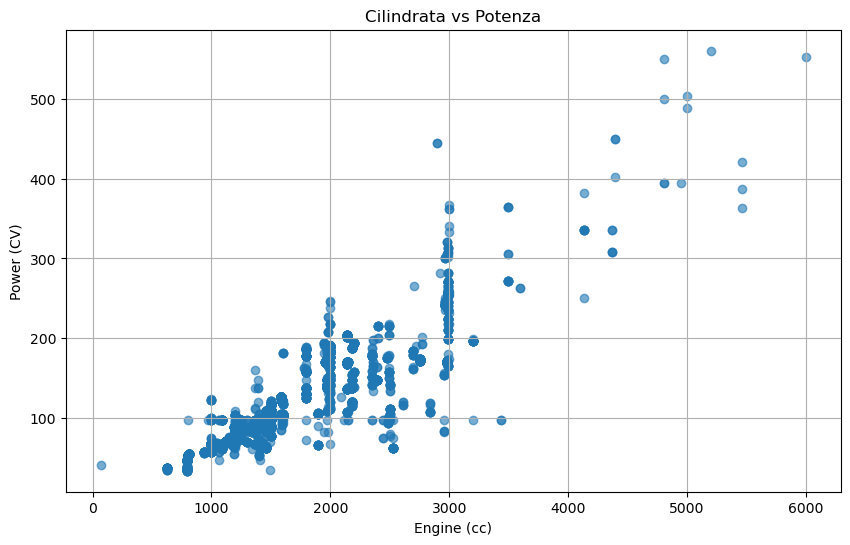

In [728]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean['Engine'], df_clean['Power'], alpha=0.6)
plt.xlabel('Engine (cc)')
plt.ylabel('Power (CV)')
plt.title('Cilindrata vs Potenza')
plt.grid(True)
plt.show()

Non sembrano esserci outliers.

**5. Power**


In [729]:
df_clean['Power'].value_counts().sort_index()

Power
34.20      7
35.00     17
35.50      1
37.00     12
37.48     12
          ..
500.00     1
503.00     1
550.00     1
552.00     1
560.00     1
Name: count, Length: 369, dtype: int64

Non sembrano esserci outliers

**6. Seats**

In [730]:
df_clean['Seats'].value_counts().sort_index()

Seats
0        1
2       16
4       99
5     5054
6       31
7      674
8      134
9        3
10       5
Name: count, dtype: int64

In [731]:
df_clean[df_clean['Seats'] < 1]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
3999,Hyderabad,2012,125000,Petrol,Automatic,First,7.77,3197,97.7,0,18.0,Audi,A4


Siamo di frontw ad un outlier, dobbiamo gestilo, potremmo riempirlo con un valore sensato: 4 ad esempio.

**7. Price**

In [732]:
df_clean['Price'].value_counts().sort_index()

Price
0.44      1
0.45      3
0.50      2
0.51      1
0.53      2
         ..
93.67     1
97.07     1
100.00    1
120.00    1
160.00    1
Name: count, Length: 1373, dtype: int64

---

## Fase 2.3: Analisi Esplorativa

In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataframe.csv')

df.head()

,Brand,Model,Location,Age,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Wagon,Mumbai,9,72000.0,CNG,Manual,First,26.6000,998,58.16,5,1.011601
1,Hyundai,Creta,Pune,4,41000.0,Diesel,Manual,First,16.7195,1582,126.20,5,2.602690
2,Honda,Jazz,Chennai,8,46000.0,Petrol,Manual,First,13.4680,1199,88.70,5,1.704748
3,Maruti,Ertiga,Chennai,7,87000.0,Diesel,Manual,First,17.6545,1248,88.76,7,1.945910
4,Audi,A4,Coimbatore,6,40670.0,Diesel,Automatic,Second,12.9200,1968,140.80,5,2.930660


### Analisi Univariata

Analisi di **Age**. (L'ha fatta anche pippo)

In [735]:
age = df['Age']
age.describe()

count    5933.000000
mean        5.491825
std         3.025650
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        14.000000
Name: Age, dtype: float64

Notiamo che il 50% delle auto rivendute ha tra i 3 e i 7 anni. Significa che auto più vecchie coprono meno fetta di mercato

Abbiamo già varie informazioni circa Age, ma visualizziamole in maniera migliore:


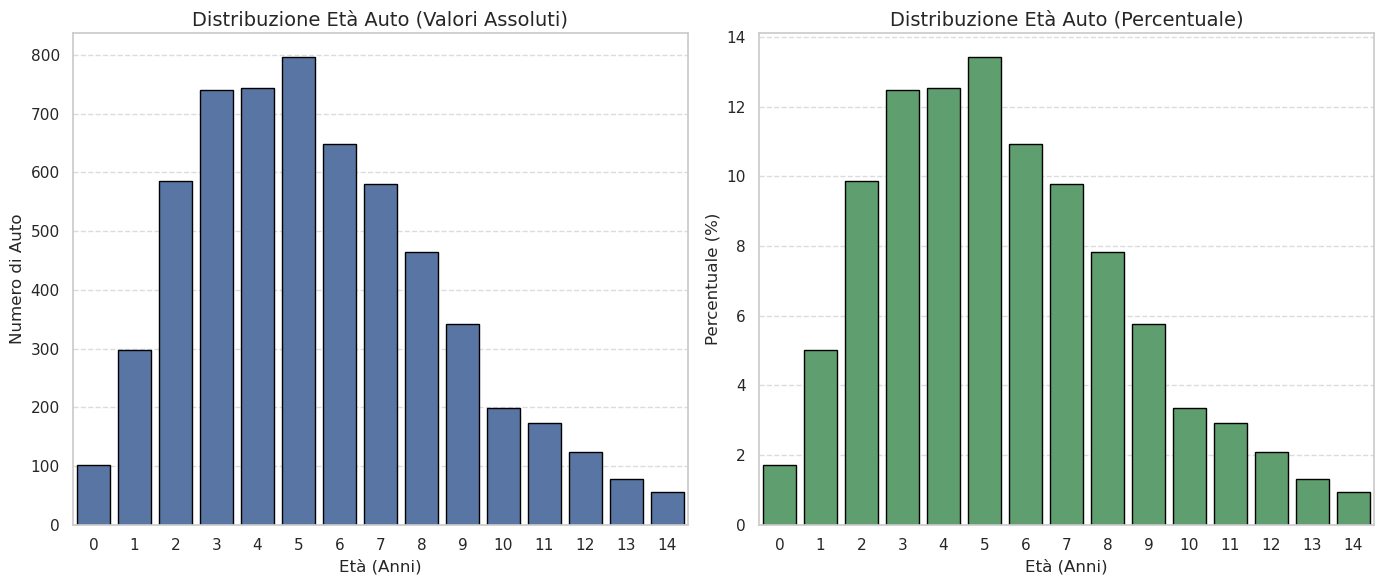

In [740]:

sns.set_style("whitegrid")


# Calcolo frequenze assolute e relative (già moltiplicate per 100 per facilità)
counts_abs = df['Age'].value_counts().sort_index()
counts_rel = (df['Age'].value_counts(normalize=True).sort_index()) * 100

# --- Creazione Grafico (Subplots) ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Grafico 1: Frequenze Assolute
# edgecolor='black' dà quel look classico e definito da report
sns.barplot(x=counts_abs.index, y=counts_abs.values, ax=axes[0], color="#4c72b0", edgecolor='black')
axes[0].set_title('Distribuzione Età Auto (Valori Assoluti)', fontsize=14) # Titolo centrato di default
axes[0].set_ylabel('Numero di Auto')
axes[0].set_xlabel('Età (Anni)')

# Grafico 2: Frequenze Relative
# Usiamo lo stesso colore o uno simile, mantenendo i bordi
sns.barplot(x=counts_rel.index, y=counts_rel.values, ax=axes[1], color="#55a868", edgecolor='black')
axes[1].set_title('Distribuzione Età Auto (Percentuale)', fontsize=14)
axes[1].set_ylabel('Percentuale (%)') # Asse chiaro per il prof
axes[1].set_xlabel('Età (Anni)')

# Aggiungiamo la griglia sull'asse Y per facilitare la lettura (spesso richiesto)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Analisi di **Transmission**

In [ ]:
transmission = df['Transmission']
transmission.describe()

count       5933
unique         2
top       Manual
freq        4223
Name: Transmission, dtype: object

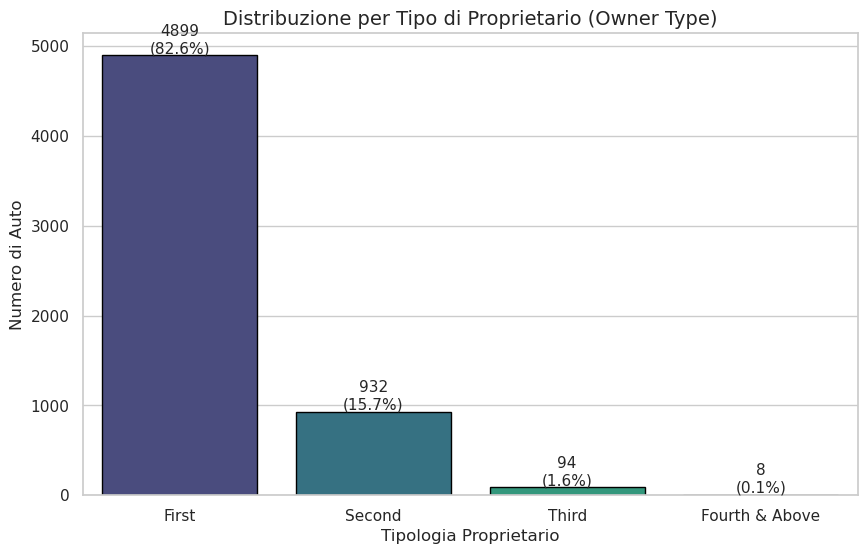

In [744]:
sns.set_style("whitegrid")

owner_counts = df['Owner_Type'].value_counts()

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=owner_counts.index, 
    y=owner_counts.values, 
    palette="viridis",
    edgecolor="black",
    hue=owner_counts.index,
    legend=False
)

plt.title("Distribuzione per Tipo di Proprietario (Owner Type)", fontsize=14)
plt.xlabel("Tipologia Proprietario", fontsize=12)
plt.ylabel("Numero di Auto", fontsize=12)

for i, v in enumerate(owner_counts.values):
    pct = (v / len(df)) * 100
    plt.text(i, v + 20, f"{v}\n({pct:.1f}%)", ha='center', fontsize=11)

plt.show()

Come già sapevamo abbiamo due diversi tipi di cambio per le auto: 'Manual' e 'Automatic'. Notiamo che la maggior parte delle auto vendute sono Manuali con ben il 71% del mercato.

Analisi di **Owner_Type**

Un auto di seconda in genere ha molto più valore di un auto di terza o quarta mano.

In [ ]:
df['Owner_Type'].describe()

count      5933
unique        4
top       First
freq       4899
Name: Owner_Type, dtype: object

Distribuzione Owner Type:
      Proprietari  Frequenza  Percentuale (%)
0           First       4899        82.572055
1          Second        932        15.708748
2           Third         94         1.584359
3  Fourth & Above          8         0.134839
------------------------------


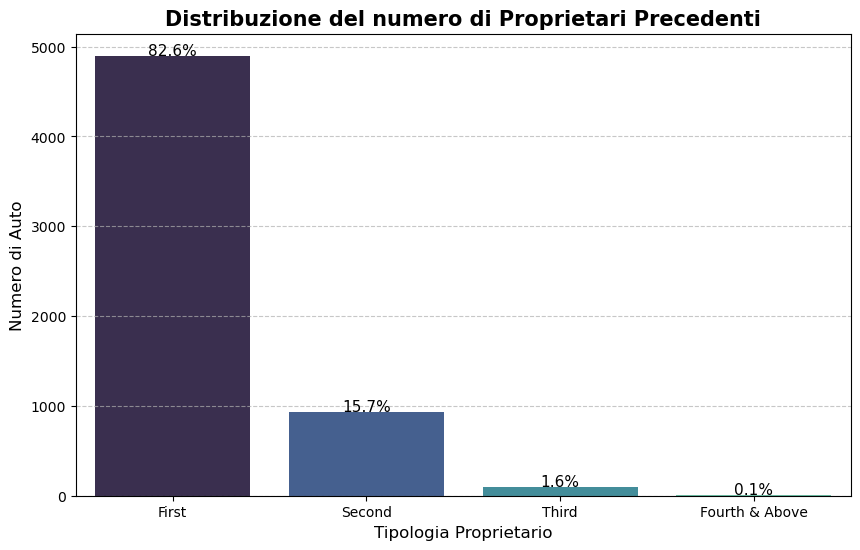

In [ ]:
owner_counts = df['Owner_Type'].value_counts().reset_index()
owner_counts.columns = ['Proprietari', 'Frequenza']
owner_counts['Percentuale (%)'] = (owner_counts['Frequenza'] / len(df)) * 100

print("Distribuzione Owner Type:")
print(owner_counts)
print("-" * 30)

plt.figure(figsize=(10, 6))

order = owner_counts['Proprietari'] 

ax = sns.barplot(
    x='Proprietari', 
    y='Frequenza', 
    hue='Proprietari',
    data=owner_counts, 
    order=order,
    palette='mako',
    legend=False
)

plt.title('Distribuzione del numero di Proprietari Precedenti', fontsize=15, fontweight='bold')
plt.xlabel('Tipologia Proprietario', fontsize=12)
plt.ylabel('Numero di Auto', fontsize=12)

for p in ax.patches:
    height = p.get_height()
    
    if height > 0:
        percentage = '{:.1f}%'.format(100 * height / len(df))
        ax.text(p.get_x() + p.get_width() / 2., height + 5, percentage, ha="center", fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La distribuzione è fortemente dominata dalla categoria *'First Owner'*, che copre circa l'83% dei casi. Quindi il dataset è composto prevalentemente da veicoli 'giovani' e ben mantenuti.

Notiamo un calo passando da *'Second'* a *'Third*' hand. Le auto con 3 o più propreitari sono statisticamente trascurabili.

Nota: Essendo una variabile ordinale, in fase di modeling potremmo assegnare dei valori numerici ad ogni etichetta. Inoltre potremmo combinare in una sola etichetta '*Third*' e '*Fourth & Above*', essenco che sono entrambe statisticamente trascurabili.

Analisi di **Mileage**.